In [70]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics
import warnings
warnings.filterwarnings("ignore")

In [36]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
#We load the data file. Format in Excel, csv.
AH_data = pd.read_csv("data/browser_os.csv")
#We change de column names
AH_data.rename(columns={'ga:operatingSystem':'OS', 'ga:browser':'browser', 'tipo':'target'}, inplace=True)
AH_data.head()

,OS,browser,target
0,Chrome OS,Chrome,no_comprador
1,Linux,Chrome,no_comprador
2,Windows,Chrome,no_comprador
3,Chrome OS,Chrome,comprador
4,Chrome OS,Chrome,no_comprador


In [4]:
#We delete data with missing values because Python cannot make trees with missing data.
data_clean = AH_data.dropna()

In [5]:
#To verify that it has been read correctly, we can list the variables in the file and extract the main statistics.
data_clean.dtypes

data_clean.describe()

,OS,browser,target
count,4980,4980,4980
unique,8,7,2
top,Windows,Chrome,no_comprador
freq,2102,2249,3937


In [6]:
#We indicate the predictor variables and below the target variable.
predictors = data_clean[['OS','browser']]

targets = data_clean['target']

In [7]:
#Encodes labels with a value between 0 and the number of classes - 1.
#That's why we use The LabelEncoder property of Sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
predictors["OS_code"] = lb_make.fit_transform(predictors["OS"])
predictors["browser_code"] = lb_make.fit_transform(predictors["browser"])
targets = lb_make.fit_transform(targets)

In [9]:
#Converts categorical variables to numeric
predictors.head(10)

,OS,browser,OS_code,browser_code
0,Chrome OS,Chrome,1,1
1,Linux,Chrome,3,1
2,Windows,Chrome,5,1
3,Chrome OS,Chrome,1,1
4,Chrome OS,Chrome,1,1
5,Linux,Firefox,3,2
6,Windows,Chrome,5,1
7,Chrome OS,Chrome,1,1
8,Android,Mozilla,0,4
9,Windows,Mozilla,5,4


In [18]:
predictors[predictors['OS_code'] == 6]

,OS,browser,OS_code,browser_code
2213,Windows Phone,Internet Explorer,6,3
3640,Windows Phone,Chrome,6,1
3890,Windows Phone,Chrome,6,1


In [20]:
targets

array([1, 1, 1, ..., 0, 1, 1])

## Pre-scanning the data

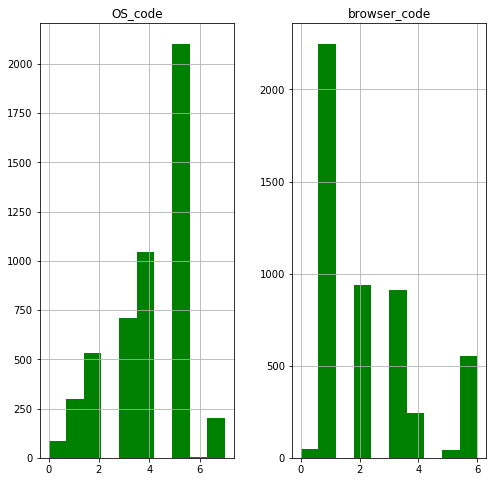

In [17]:
predictors.hist(figsize = (8, 8), color='g');

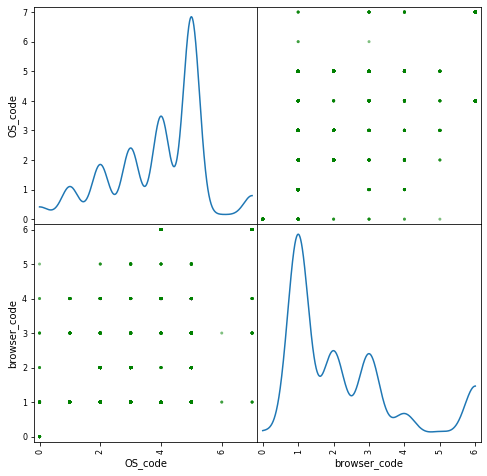

In [19]:
from pandas.plotting import scatter_matrix

scatter_matrix(predictors, figsize = (8, 8), diagonal = 'kde', color='g');

### Creating a training and validation dataset

In [43]:
#We create the training and test sample, both for predictors and for the target variable, being tested 40%.
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.4, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(predictors[['OS_code', 'browser_code']], targets, test_size=.4, random_state = 42)

In [55]:
#Comprobamos el tamaño de las diferentes muestras (pred=predictora; tar=target, objetivo). 
#La salida en cada caso es una pareja de datos: el tamaño de la muestra y el número de variables.
x_train.shape

(2988, 2)

In [58]:
x_test.shape

(1992, 2)

In [32]:
y_train.shape

(2988,)

In [33]:
y_test.shape

(1992,)

### Metric Function¶

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

def metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    print(u'Confusion Matrix \n', cm)

    print(u'Accurancy:', accuracy_score(y_true, y_pred))
    print(u'Precision:', precision_score(y_true, y_pred))
    print(u'Recall:', recall_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print(u'AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title(u'AUC = %0.2f' % roc_auc)

### Creating model

In [45]:
#We build the decision tree model with the training data
#we tested with a depth of 7
classifier=DecisionTreeClassifier(max_depth=7,random_state=100)

#Le pasamos únicamente las variables de las etiquetas
classifier.fit(pred_train[['OS_code','browser_code']],tar_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

Confusion Matrix 
 [[   5  634]
 [   3 2346]]
Accurancy: 0.786813922356091
Precision: 0.7872483221476511
Recall: 0.9987228607918263
AUC: 0.5032737934632058


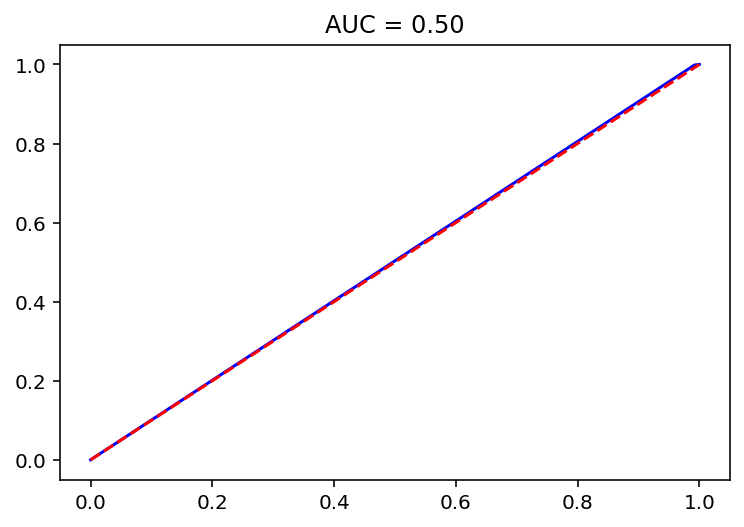

In [76]:
#We build the decision tree model with the training data
#we tested with a depth of 7
tree = DecisionTreeClassifier(criterion = 'gini',
                              max_depth = 5,
                              random_state = 100)
tree.fit(x_train, y_train)
y_pred_train = tree.predict(x_train)

metrics(y_train, y_pred_train)

Confusion Matrix 
 [[   1  403]
 [   2 1586]]
Accurancy: 0.7966867469879518
Precision: 0.7973856209150327
Recall: 0.9987405541561712
AUC: 0.5006079008404619


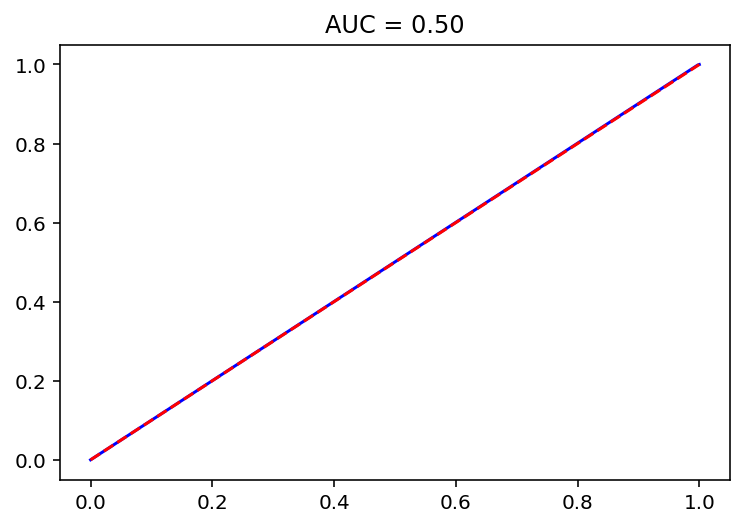

In [78]:
#Comprobamos que no existe sobreajuste con el df test
y_pred_test = tree.predict(x_test)
metrics(y_test, y_pred_test)

We analyze what can be the optimal parameter for "max_depth"

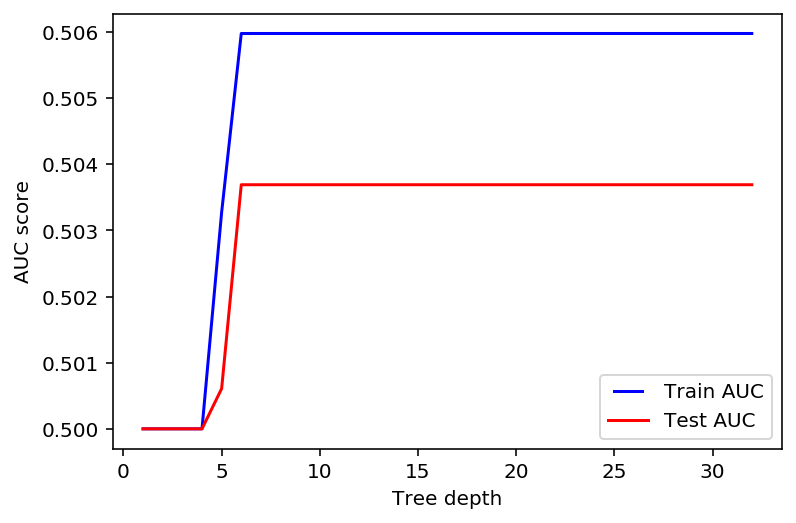

In [66]:
from sklearn.tree import DecisionTreeClassifier
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label='Train AUC')
line2, = plt.plot(max_depths, test_results, "r", label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Confusion Matrix 
 [[   9  630]
 [   5 2344]]
Accurancy: 0.7874832663989291
Precision: 0.7881640887693342
Recall: 0.9978714346530438
AUC: 0.5059779708476486


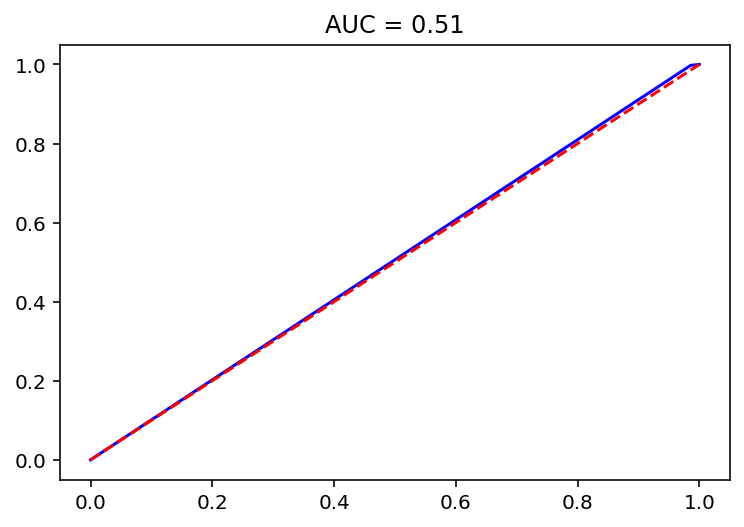

In [79]:
#We build the decision tree model with the training data
#we tested with a depth of 6
tree = DecisionTreeClassifier(criterion = 'gini',
                              max_depth = 6,
                              random_state = 100)
tree.fit(x_train, y_train)
y_pred_train = tree.predict(x_train)

metrics(y_train, y_pred_train)

### Randon Forrest

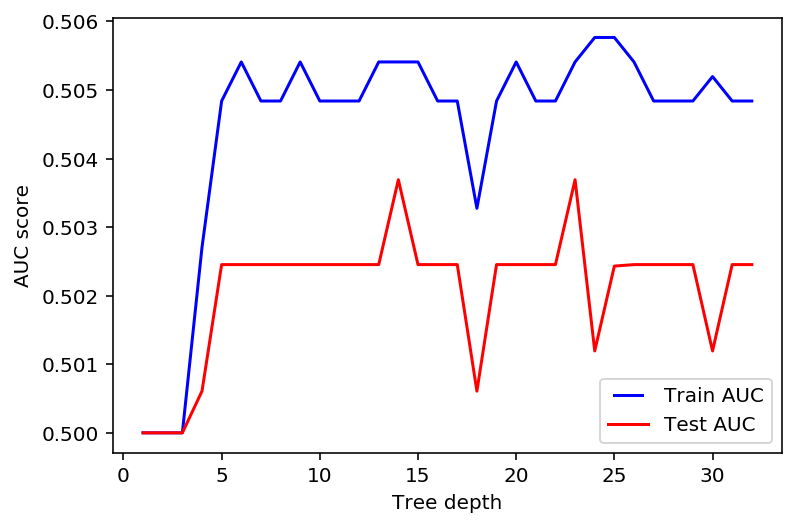

In [71]:
from sklearn.ensemble import RandomForestClassifier

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label='Train AUC')
line2, = plt.plot(max_depths, test_results, "r", label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show();

Confusion Matrix 
 [[   0  639]
 [   0 2349]]
Accurancy: 0.786144578313253
Precision: 0.786144578313253
Recall: 1.0
AUC: 0.5


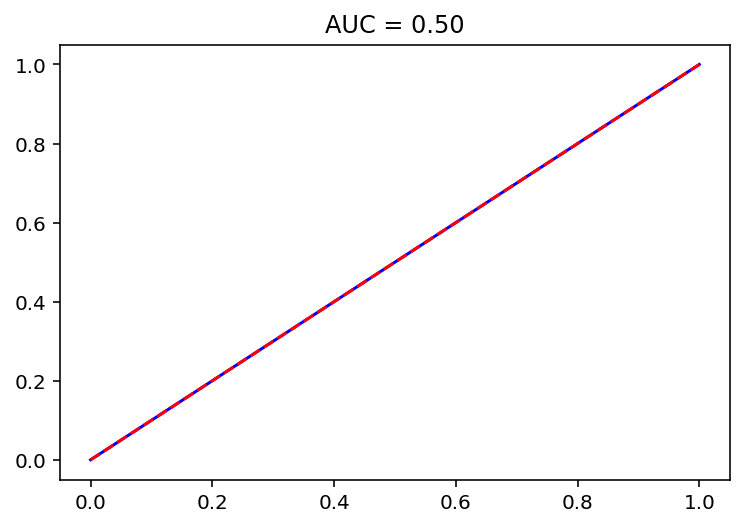

In [80]:
rf_classifier = RandomForestClassifier(n_estimators = 5, max_depth=4,
                                       random_state = 1)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_train)

metrics(y_train, y_pred)

Confusion Matrix 
 [[   0  404]
 [   0 1588]]
Accurancy: 0.7971887550200804
Precision: 0.7971887550200804
Recall: 1.0
AUC: 0.5


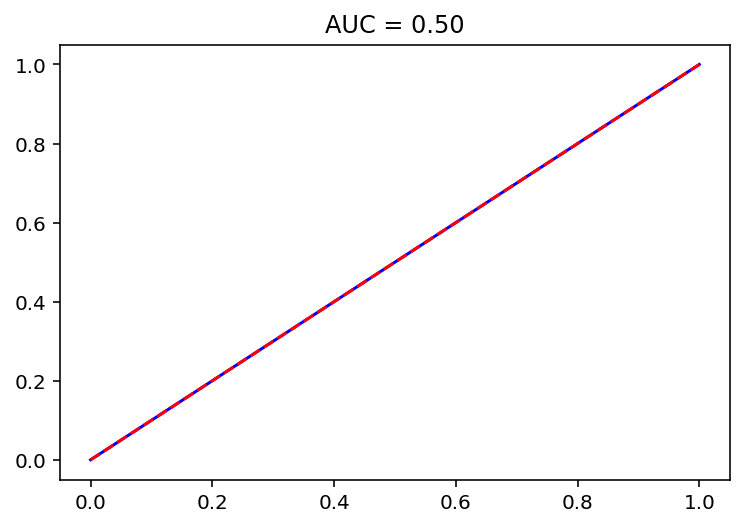

In [81]:
y_test_pred = rf_classifier.predict(x_test)
metrics(y_test, y_test_pred)

In [83]:
#To draw the tree we have to install the following libraries
from sklearn import tree
from io import StringIO
from IPython.display import Image

In [84]:
out = StringIO()
tree.export_graphviz(classifier, out_file='exampletree.dot')

This will create a file with dot extension and we need the graphviz software to pass it to png so that we can see it. To do this first we download the program from the URL: http://www.graphviz.org/download/, install it and then go to the installation directory where we will find the dot.exe file. Finally we will run dot.exe with the paths of the dot file and where you want to save the image: dot -Tpng treeexample.dot -o treeexample.png